In [1]:
import keras
import h5py as h5
import numpy as np
import pandas as pd
PATH_DATA = 'data/train/eightieth.h5' #'data/pred_teachers/pred_eighties_from_half_1.h5'
PATH_PREDICT_WITHOUT_GT = 'data/pred_students/pred_eighties_from_half_1_without_gt.h5' #'data/pred_students/pred_eighties_from_full_1_without_gt.h5' 
PATH_SUBMIT = 'data/submit/pred_eighties_from_half_1_AWESOMEGROUP.h5'
PATH_SUBMIT1 = 'data/submit/pred_eighties_from_half_1_5tars.csv'
PATH_PREDICT_WITH_GT = 'data/pred_teachers/pred_eighties_from_half_1.h5'

C:\Users\RASSB\Anaconda3\envs\tensorflowgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

In [3]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [80]:
def verify(x,labels):
    if x in labels:
        for i in range (len(labels)):
            if labels[i] == x:
                return i
        return Null
    
def recover(y_pred,labels):
    for i in range (len(labels)):
        if labels[i] == x:
                return x
        return Null   
    
def countLabel(h5_path,label):
    nb = 0
    f = h5.File(h5_path, 'r')
    Y =  f['TOP_LANDCOVER'][:]
    for i in range(len(Y)):
        if Y[i] == label: 
            nb += 1
    return nb

def filterClass(h5_path, labels):
    X = []
    f = h5.File(h5_path, 'r')
    Y =  f['TOP_LANDCOVER'][:]
    for i in range(len(Y)):
        A = verify(Y[i],labels)
        if A != None:
            X.append (i)
    return X

In [ ]:
'''
def filterClass123(h5_path):
    X = []
    f = h5.File(h5_path, 'r')
    Y =  f['TOP_LANDCOVER'][:]
    for i in range(len(Y)):
        if Y[i] == 1: 
            a1 += 1
            X.append(i)
        elif Y[i] == 2:
            a2 += 1
            X.append(i)
        elif Y[i] == 3:
            a3 += 1
            X.append(i)
    return X, a1, a2, a3 '''

In [20]:
X,a1,a2,a3 = filterClass123(PATH_DATA)

print(a1)
print(a2)
print(a3)

10988
29178
39369


In [42]:
countLabel(PATH_DATA,19)

6

In [75]:
labels = [19]

In [76]:
filterClass(PATH_DATA,labels)

[71689, 71690, 71753, 71754, 197545, 197609]

In [53]:
print( verify(5,labels) )

None


In [6]:
def generatorFilter(h5_path,batch_size,idxs,labels):
    f= h5.File(h5_path,'r')
    while True : 
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = f['S2'][batch_idxs, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), len(labels))
    

In [7]:
train_idxs, val_idxs = split_train_val(X, 0.2)

train_gen = generatorFilter(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generatorFilter(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [10]:
input_shape = (16,16,4)
from keras.models import Model
from keras.layers import Input, Conv3D, Conv2D, Dropout, MaxPooling2D, Flatten, Activation, AveragePooling2D, concatenate, add



inp = Input(shape = input_shape)

x1 = Conv2D(32, (3,3))(inp)
x1 = BatchNormalization(axis=-1)(x1)
x1 = Activation("relu")(x1)

x2 = Conv2D(32, (1,1))(x1)
x2 = BatchNormalization(axis=-1)(x2)
x2 = Activation("relu")(x2)


conc1 = concatenate([x1, x2])
conc1 = MaxPooling2D(pool_size = (2,2))(conc1)


x3 = Conv2D(64, (3,3))(conc1)
x3 = BatchNormalization(axis=-1)(x3)
x3 = Activation("relu")(x3)

x4 = Conv2D(64, (1,1))(x3)
x4 = BatchNormalization(axis=-1)(x4)
x4 = Activation("relu")(x4)

conc2 = concatenate([x3, x4])
conc2 = MaxPooling2D(pool_size = (2,2))(conc2)

x5 = Flatten()(conc2)


x5 = Dense(128)(x5)
x5 = BatchNormalization()(x5)
x5 = Activation("relu")(x5)
x5 = Dropout(0.2)(x5)
x5 = Dense(3)(x5)
x5 = Activation('softmax')(x5)

model = Model(inp, x5)

optim = keras.optimizers.Adam(lr=0.0001)
#optim = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
history = model.fit_generator(train_gen, steps_per_epoch=100, epochs=15, verbose=2, validation_data=val_gen, nb_val_samples=100,shuffle=True)

C:\Users\RASSB\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\__main__.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
C:\Users\RASSB\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=100, epochs=15, verbose=2, validation_data=<generator..., shuffle=True, validation_steps=100)`
  if __name__ == '__main__':


Epoch 1/15
 - 4s - loss: 1.0214 - acc: 0.5041 - val_loss: 1.0532 - val_acc: 0.4913
Epoch 2/15
 - 4s - loss: 0.9708 - acc: 0.5341 - val_loss: 0.8188 - val_acc: 0.6247
Epoch 3/15
 - 4s - loss: 1.0261 - acc: 0.4628 - val_loss: 0.9637 - val_acc: 0.4756
Epoch 4/15
 - 3s - loss: 0.8659 - acc: 0.6331 - val_loss: 1.2099 - val_acc: 0.4006
Epoch 5/15
 - 3s - loss: 1.0083 - acc: 0.5134 - val_loss: 1.1995 - val_acc: 0.4472
Epoch 6/15
 - 4s - loss: 0.9523 - acc: 0.5506 - val_loss: 0.9963 - val_acc: 0.5297
Epoch 7/15
 - 4s - loss: 1.0061 - acc: 0.4813 - val_loss: 0.8036 - val_acc: 0.6028
Epoch 8/15
 - 3s - loss: 1.1625 - acc: 0.4178 - val_loss: 0.9877 - val_acc: 0.4653
Epoch 9/15
 - 4s - loss: 1.0552 - acc: 0.4391 - val_loss: 1.1154 - val_acc: 0.3784
Epoch 10/15
 - 4s - loss: 0.9480 - acc: 0.5306 - val_loss: 1.2075 - val_acc: 0.4551
Epoch 11/15
 - 4s - loss: 1.0958 - acc: 0.4341 - val_loss: 0.9667 - val_acc: 0.4450
Epoch 12/15
 - 4s - loss: 0.9932 - acc: 0.4612 - val_loss: 0.9453 - val_acc: 0.3700
E

## Prediction routines

In order to submit a result here are some gits

In [15]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        cm = cm.astype('float')/1.0
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes

def noclean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        #if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
        real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes



241700
7554/7554 [==============================] - 39s 5ms/step
241700
Normalized confusion matrix


<IPython.core.display.Javascript object>


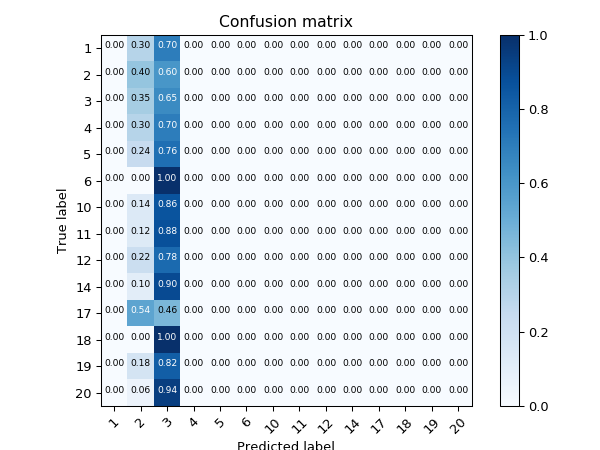

0.1394290442697559

In [16]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction))

gt_gen = gt_generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

%matplotlib notebook
from sklearn.metrics import confusion_matrix
y_true = np.argmax(gt, axis=1)
y_pred = np.argmax(prediction, axis = 1) +1

#y_true = y_pred

real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=True)


somme = 0
for i in range (len(real_cnf_matrix)):    
    somme = somme + real_cnf_matrix[i,i] 
somme_t = sum(sum(real_cnf_matrix))
somme/somme_t
